In [1]:
%matplotlib inline
import numpy as np
import re
import pandas as pd
import orbipy as op
import matplotlib.pyplot as plt
import pickle

In [2]:
import dill

In [3]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)
plotter = op.plotter.from_model(model, length_units='km', velocity_units='m/s')
scaler = plotter.scaler

In [4]:
class Hyperbolic:
    def __init__(self):
        self.c2 = self.calc_c2()
        self.lam = self.calc_lam()
        self.omega = self.calc_omega()
        self.k1 = self.calc_k1()
        self.k2 = self.calc_k2()
        self.k3 = self.calc_k3()
        self.k4 = self.calc_k4()
        
    def p1(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p1_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def calc_vy(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return (self.k3*self.omega*x+(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega)*(self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/self.k1
        
    def calc_c2(self):
        r1 = np.abs(model.L1+model.mu)
        r2 = np.abs(model.L1+model.mu-1)
        
        return (1.-model.mu)/r1**3+model.mu/r2**3
    
    def calc_lam(self):
        return np.sqrt((self.c2-2+np.sqrt(9*self.c2**2-8*self.c2))/2)
    
    def calc_omega(self):
        return np.sqrt((-1.*self.c2+2+np.sqrt(9*self.c2**2-8*self.c2))/2)
        
    def calc_k1(self):
        return -2/(self.c2+3+self.lam**2)
    
    def calc_k2(self):
        return -2/(2*self.c2+1-self.lam**2)
    
    def calc_k3(self):
        return (self.omega*(self.c2-1+self.lam**2))/((self.c2-1)*(self.c2+3+self.lam**2))
    
    def calc_k4(self):
        return (self.lam*(-2*self.c2+3+self.lam**2))/((self.c2-1)*(-2*self.c2-1+self.lam**2))

In [38]:
class CanonicTransform:
    def __init__(self, data_path, model):
        self.mu = model.mu
        self.gamma = 1.-model.mu-model.L1
        self.formula = dill.load(open(data_path, "rb"))
        
    def apply_shift_scale(self, states):
        shift = (self.gamma+self.mu-1)/self.gamma
        states_new = states/self.gamma
        states_new[:,3] -= states[:,1]/self.gamma
        states_new[:,4] += states[:,0]/self.gamma
        states_new[:,0] += shift
        states_new[:,4] += shift
        return states_new
    
    def apply(self, states):
        arr = self.apply_shift_scale(states)
        result = self.formula(arr[:,0],arr[:,1],arr[:,2],arr[:,3],arr[:,4],arr[:,5])
        return result

In [55]:
x0 = model.L1 + scaler(1000, 'km-nd')
z0 = scaler(1000, 'km-nd')
s0 = model.get_zero_state()
s0[0] = x0
s0[2] = z0

In [56]:
EL1_dist = 1.-model.mu - model.L1
left = op.eventXleft = op.eventX(model.L1-EL1_dist)
right = op.eventX(1.-model.mu)

In [57]:
corr = op.border_correction(model, op.y_direction(), left, right)

In [58]:
sk = op.simple_station_keeping(precise_model,corr, corr)

In [59]:
# orb = orbs[-5]

In [60]:
orb = sk.prop(0.0, s0, 30)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


## Исходня исследуемая орбита

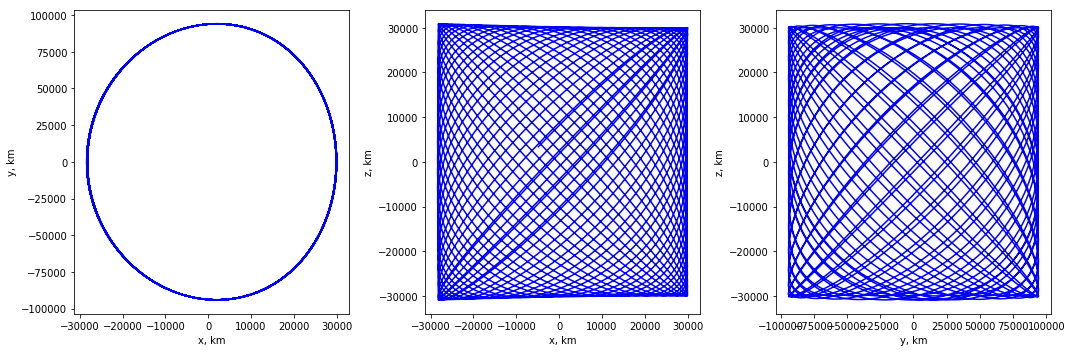

In [61]:
ax = plotter.plot_proj(orb, centers={'x': model.L1, 'y': 0.0, 'z': 0.0})
#plotter.plot_proj(ax=ax, plottables = [plotter.m], marker = 'o')

In [74]:
hyp = Hyperbolic()
orb_h1 = hyp.p1_table(orb.drop('t', axis=1))

orb_states = orb.drop('t', axis=1).to_numpy()

ct_x3 = CanonicTransform('./x3.bin', model)
orb_x3 = ct_x3.apply(orb_states)

ct_x4 = CanonicTransform('./x4.bin', model)
orb_x4 = ct_x4.apply(orb_states)

ct_x5 = CanonicTransform('./x5.bin', model)
orb_x5 = ct_x5.apply(orb_states)

ct_px3 = CanonicTransform('./px3.bin', model)
orb_px3 = ct_px3.apply(orb_states)

ct_px4 = CanonicTransform('./px4.bin', model)
orb_px4 = ct_px4.apply(orb_states)

ct_px5 = CanonicTransform('./px5.bin', model)
orb_px5 = ct_px5.apply(orb_states)

## Траектория в плоскости TH1 (H1 - неустойчивая компонента выраженная из решения)

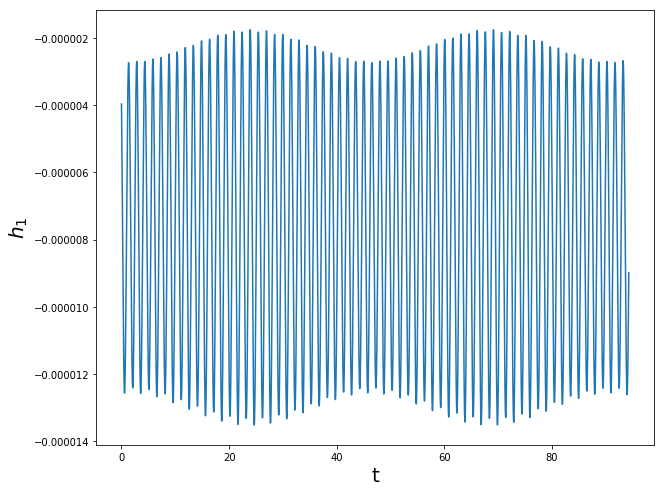

In [63]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$h_1$", fontsize=20)
plt.plot(orb['t'], orb_h1)

## Траектория в плоскости $T\hat{X}$ (после зануления мономов степени 3)

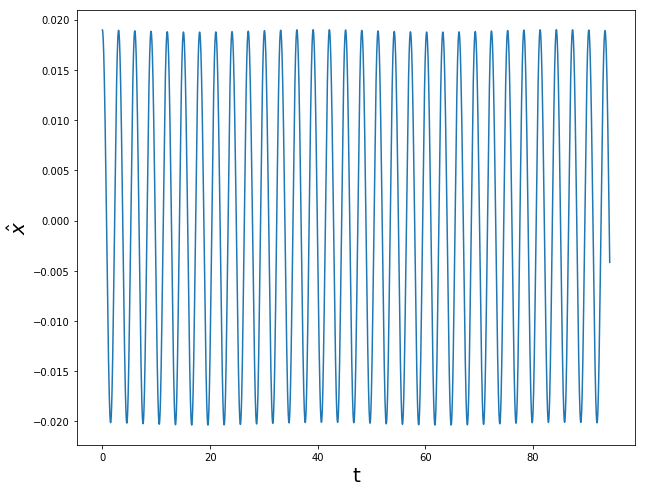

In [64]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\hat{x}$", fontsize=20)
plt.plot(orb['t'], orb_x3)

## Траекториия в плоскости $T\tilde{X}$ (после зануления мономов степени 4)

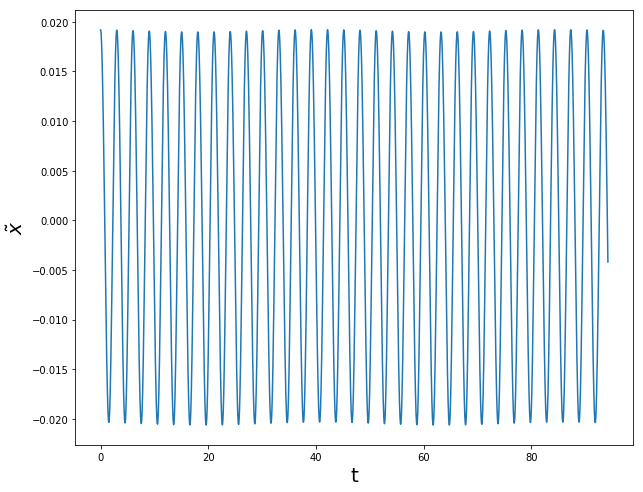

In [65]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\\tilde{x}$", fontsize=20)
plt.plot(orb['t'], orb_x4)

## Траекториия в плоскости $T\bar{X}$ (после зануления мономов степени 5)

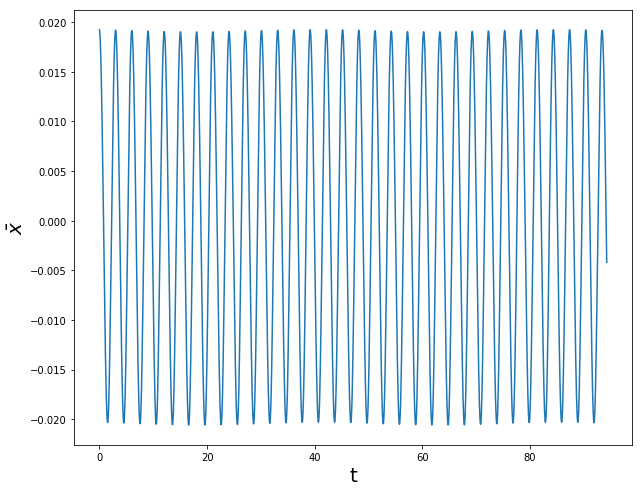

In [72]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\\bar{x}$", fontsize=20)
plt.plot(orb['t'], orb_x5)

## Траектория в плоскости $T(\tilde{X}-\hat{X})$

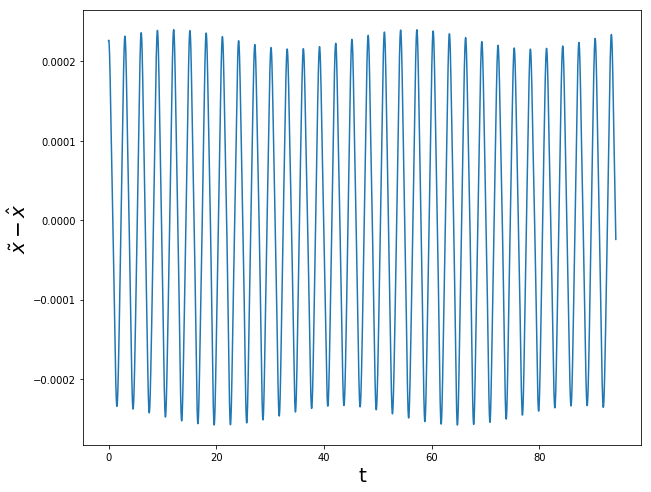

In [66]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\\tilde{x}-\hat{x}$", fontsize=20)
plt.plot(orb['t'], orb_x4-orb_x3)

## Траектория в плоскости $T(\bar{X}-\tilde{X})$

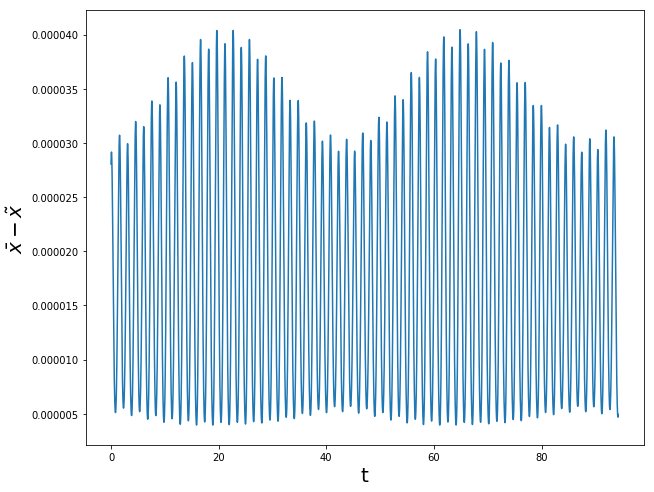

In [73]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\\bar{x}-\\tilde{x}$", fontsize=20)
plt.plot(orb['t'], orb_x5-orb_x4)

## Траектории в плоскости $T\hat{P_X}$ (после зануления мономов степени 3)

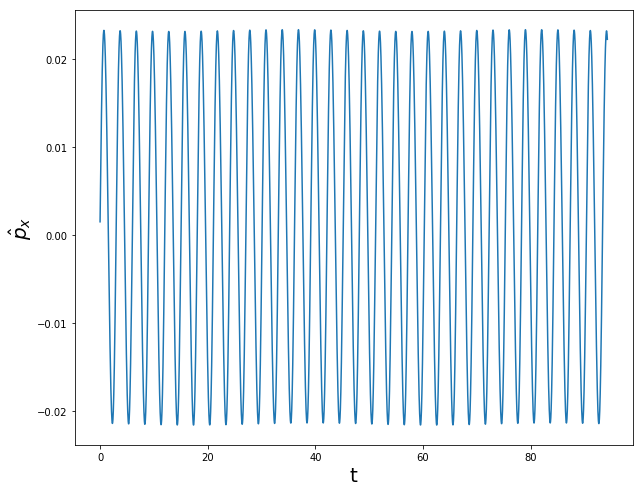

In [67]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\hat{p}_x$", fontsize=20)
plt.plot(orb['t'], orb_px3)

## Траектории в плоскости $T\tilde{P}_X$ (после зануления мономов степени 4)

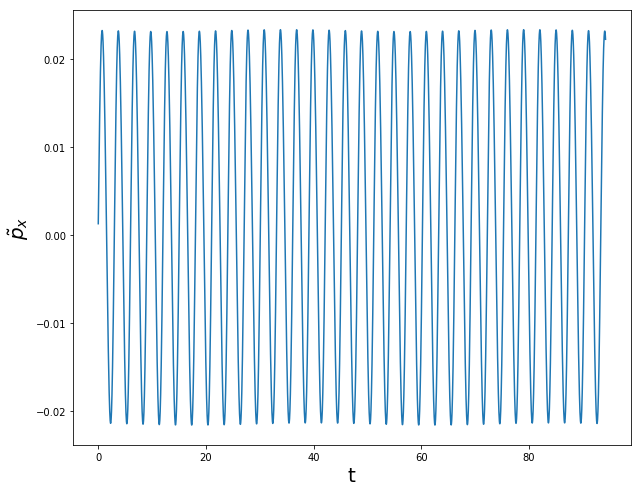

In [68]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\\tilde{p}_x$", fontsize=20)
plt.plot(orb['t'], orb_px4)

## Траектории в плоскости $T\bar{P}_X$ (после зануления мономов степени 5)

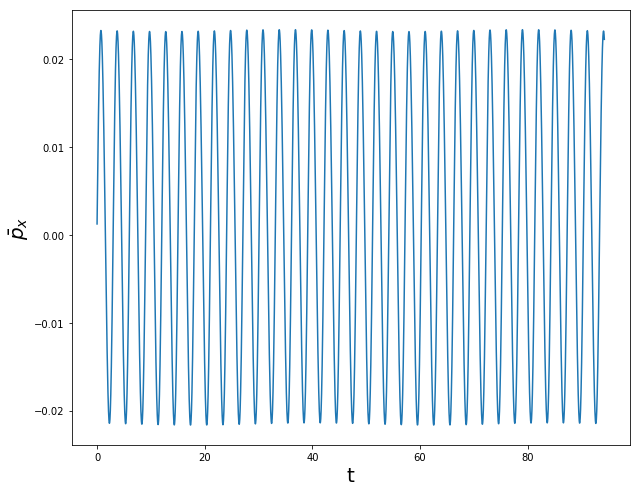

In [75]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\\bar{p}_x$", fontsize=20)
plt.plot(orb['t'], orb_px5)

## Траектория в плоскости $T(\tilde{P}_X-\hat{P}_X)$

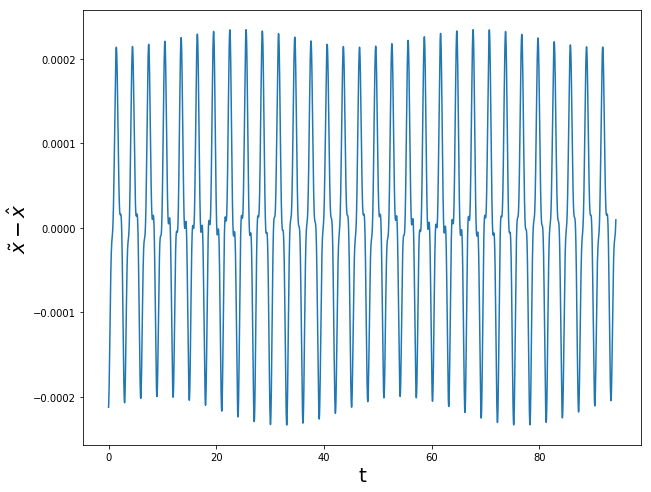

In [69]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\\tilde{x}-\hat{x}$", fontsize=20)
plt.plot(orb['t'], orb_px4-orb_px3)

## Траектория в плоскости $T(\bar{P}_X-\tilde{P}_X)$

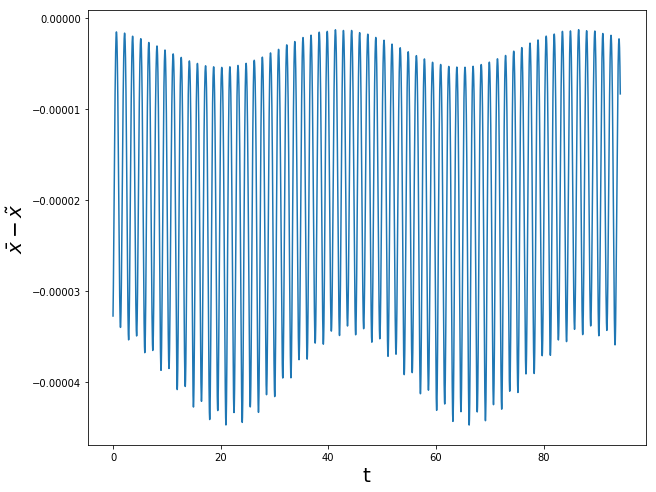

In [76]:
plt.figure(figsize=(10,8))
plt.xlabel('t', fontsize=20)
plt.ylabel("$\\bar{x}-\\tilde{x}$", fontsize=20)
plt.plot(orb['t'], orb_px5-orb_px4)